### Introduction
This notebook aims to visualize the results obtained from HW1 and HW2. The information obtained or inferred from 'weibo_data.xlsx' will be visualized.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import wordcloud
import re
import numpy as np
import datetime
import glob

### Read weibo data

In [2]:
df_data = pd.read_excel('weibo_data.xlsx')
df_data.head(1)

,Username,Post_datetime,Content,Video_link(expired),Repost_Count,Comment_Count,Like_Count,Keywords,Video_file
0,Ice-dance柳鑫宇,2022-03-05 16:10:00,我用了我很喜欢的一首歌曲来当背景音乐，来与大家分享我的闭幕式vlog，北京冬奥会真的结束了，...,https://f.video.weibocdn.com/o0/b7tMvrhxlx07Uf...,939,1532,29070,#冬奥会# #冬奥隔离日记#,./video/1.mp4


### Plot distibution of post datetime

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, ''),
  Text(1, 0, '')])

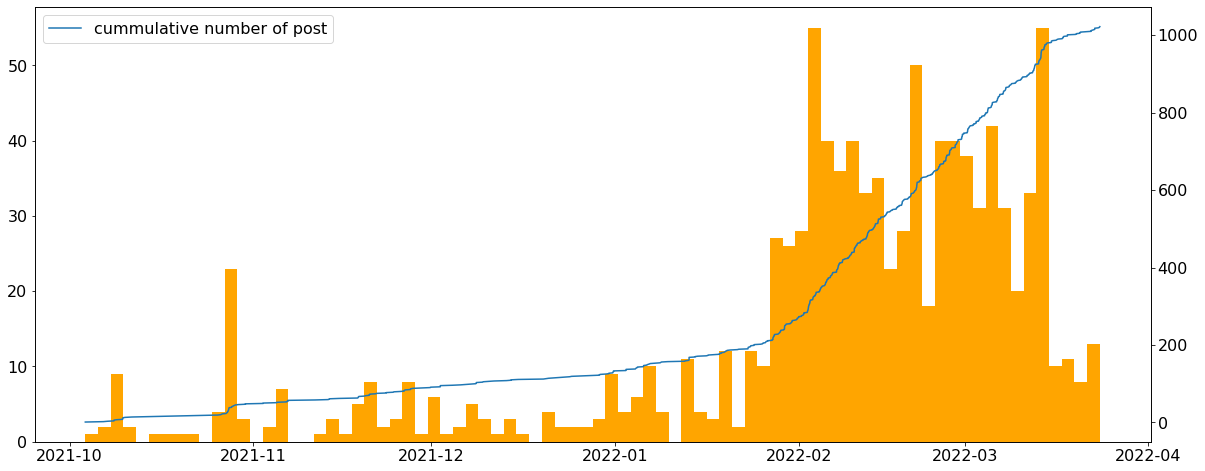

In [3]:
df_sc = df_data.copy()
df_sc = df_sc[df_sc['Post_datetime']>= datetime.datetime(2021, 10, 1)]
df_sc.sort_values(by = ['Post_datetime'], inplace=True)
df_sc['num_of_post'] = np.cumsum([1]*len(df_sc))
fig, ax = plt.subplots(figsize = (20,8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.hist(df_sc['Post_datetime'], bins=80, color='orange')
ax2 = ax.twinx()
ax2.plot(df_sc['Post_datetime'], df_sc['num_of_post'], label='cummulative number of post')
ax2.legend(fontsize=16)
plt.yticks(fontsize=16)


From the above figure, we can see that most of the collected posts are issued after January of 2022.

### Generate Wordcloud based on Content of Each Post

In [4]:
def to_wordcloud(df_data, filename):
    # Split chinese sentences into words and phrases
    all_content = [row['Content'] for idx, row in df_data.iterrows()]
    all_content = ' '.join(all_content)
    unwanted = re.compile('[!，?#：（）。·《》／、@……&“”！【】|｜....____↓？]|  |\ue627')
    all_content = unwanted.sub('', all_content)
    splited_content = jieba.lcut(all_content)
    # Remove unwanted words and choose words with length >= 2
    unwanted_words = ['展开','微博','视频']
    splited_content = [i for i in splited_content if len(i)>1 and i not in unwanted_words]
    splited_content = ' '.join(splited_content)
    # Generate wordcloud
    w = wordcloud.WordCloud(width=1000, height=800, background_color = 'white', font_path = r'C:\Windows\Fonts\simhei.ttf', max_words = 50, collocations=False)
    w.generate(splited_content)
    w.to_file(filename)

In [6]:
to_wordcloud(df_data, 'result.png')

### Generate Wordcloud for each period
The posts are classified into different groups based on their post datetime. Wordcloud is then generated for each group.

In [10]:
for idx, df in df_sc.groupby(pd.cut(df_sc['Post_datetime'], 6)):
    left_date = idx.left.date()
    right_date = idx.right.date()
    filename = '{} to {}.png'.format(left_date, right_date)
    to_wordcloud(df, filename)


It is worth noting that during 2022-01-25 to 2022-02-23, 'Winter Olympics'(冬奥会) is a major keyword shown in the figure. Then in the next period, 2022-02-23 to 2022-03-23, 'Paralympic Games'(残奥会) become a major keyword. This matches the opening time of 2022 Beijing Winter Paralympic Games.

### Count cumulative number of occurrence of a set of words by date

In [7]:
def cumulative_number(df_sc, interested_sets):
    for s in interested_sets:
        sc = [1]*len(df_sc)
        i = 0
        for idx, row in df_sc.iterrows():
            for item in s:
                if item not in row['Content']:
                    sc[i] = 0
            i+=1
        df_sc['sc: {}'.format(s)] = sc
    return df_sc

In [8]:
interested_sets = [[['云顶滑雪公园'], ['张家口'], ['云顶滑雪公园','张家口']],
                   [['雪车雪橇'], ['延庆'], ['雪车雪橇','延庆']],
                   [['苏翊鸣'], ['单板滑雪'], ['苏翊鸣','单板滑雪']],
                   [['谷爱凌'], ['自由式滑雪'], ['谷爱凌','自由式滑雪']],
                   [['冰立方'], ['冰壶'], ['冰立方','冰壶']],
                   [['冰丝带'], ['速度滑冰'], ['冰丝带','速度滑冰']],
                   [['雪容融'], ['残奥'], ['雪容融','残奥']],
                   [['残奥', '鸟巢'], ['开幕'], ['残奥', '鸟巢','开幕']]]


df_sc = df_data.copy()
df_sc = df_sc[df_sc['Post_datetime']>= datetime.datetime(2021, 10, 1)]
df_sc.sort_values(by=['Post_datetime'], inplace=True)
for idx, sets in enumerate(interested_sets):
    rule = '{} -> {}'.format(sets[0], sets[1])
    df_sc = cumulative_number(df_sc, sets)
    for s in sets:
        df_sc['cummulative_sc: {}'.format(s)] = np.cumsum(df_sc['sc: {}'.format(s)])




Suppose a rule has the form {A1, A2, …} -> {B1, B2, …}. We can plot the cumulative number of occurence of sets {A1, A2, …} , {B1, B2, …} and {A1, A2, …, B1, B2, …} respectively to obtain 3 time series. If the rule is valid, then the series {A1, A2, …} should be highly positively correlated with series {A1, A2, …, B1, B2, …}. Because the conditional probability P(B1, B2, …|A1, A2, …) = P(A1, A2, …, B1, B2, …)/P(A1, A2, …) should have a relatively high value.